# Introduction

In this project, we will create a web app for book recommendation using machine learning algorithm.

We will be using the dataset from Kaggle: [Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?datasetId=1004280)

## The Dataset

The Book-Crossing dataset comprises 3 tables.
1. BX-Users <br>
Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (`Location`, `Age`) if available. Otherwise, these fields contain NULL-values.

1. BX-Books <br>
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.

1. BX-Book-Ratings <br>
Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

# What Can You Expect In this Notebook?

## Goals
1. Data preparation
1. EDA

## Steps
In this notebook we will do the following:
1. Data cleaning
1. EDA of each dataset
1. Feature engineering

# Data Preparation

In [1]:
# import libraries (you may add additional imports but you may not have to)
import logging
logging.captureWarnings(True)

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
from scipy.sparse import csr_matrix

#viz lib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

#to scale the data using z-score
from sklearn.preprocessing import StandardScaler

#Importing PCA
from sklearn.decomposition import PCA

In [35]:
books = pd.read_csv("data/Books.csv")
ratings = pd.read_csv("data/Ratings.csv")
users = pd.read_csv("data/Users.csv")

In [3]:
# def make_clickable(val):
#     return '<a target="_blank" href="{}">Goodreads</a>'.format(val, val)

def show_image(val):
    return '<a href="{}"><img src="{}" width=50></img></a>'.format(val, val)

books.head().style.format({'Image-URL-S': show_image})

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [4]:
books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/185326119X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/225307649X.01.LZZZZZZZ.jpg
freq,1,27,632,13903,7535,2,2,2


In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [6]:
# checking if there are values other than digits in all columns

print("columns with non digit value")

for i in books.columns:
    print(i,books[i].str.isdigit().any())

columns with non digit value
ISBN True
Book-Title True
Book-Author True
Year-Of-Publication True
Publisher True
Image-URL-S False
Image-URL-M False
Image-URL-L False


As seen from the `info` and `isdigit` check, year of publication is in the wrong format.<br>
To do
1. For ease in accessing the columns name, we will rename the column name and use snake format.
1. Fix `year of publication` by converting the format to `int`.
1. Pop `image_url_` columns

In [43]:
# rename the columns name
def col_rename_f(data = books):
    col_rename = {i:i.lower().replace("-","_") for i in data.columns}

    data = data.rename(
        columns = col_rename
    )

    return data

books_clean = books.copy(deep = True)

books_clean = col_rename_f(books_clean)

In [44]:
# list the indexes of weird records

weird_author = books_clean[books_clean["book_author"].str.contains(r'\\') == True]['isbn']
weird_title = books_clean[books_clean["year_of_publication"].str.isdigit()==False].index.tolist()

# there are 3 rows that have a shifted records, fix it here
for i in weird_title:
    for j,k in zip(books_clean.columns[:1:-1].tolist(), range(7,1,-1)):
        books_clean.at[i, books_clean.iloc[i].index[k]] = books_clean.iloc[i][books_clean.columns.get_loc(j) - 1]

for i in weird_title:
    books_clean.at[i,"book_author"] = books_clean.iloc[weird_title]['book_title'].str.split(r'\\', expand = True)[1][i]

# cleaning the author name
books_clean["book_author"] = books_clean["book_author"].replace(
    to_replace = ['"',r'\\'],
    regex=True,
    value = "",
)

# books_clean[books_clean['isbn'].isin(weird_author.values)]

In [45]:
images = books_clean.drop(books_clean.columns[1:5], axis=1)

books_clean = books_clean.drop(books_clean.columns[5:], axis=1)

books_clean["year_of_publication"] = books_clean["year_of_publication"].astype('int')

In [46]:
# drop books with unknown year of publishing (optional)
# books_clean = books_clean[books_clean["year_of_publication"]!=0]

In [47]:
# standardize the writing style
books_clean['book_author'] = books_clean['book_author'].str.title()

In [58]:
# create mod title column to ease the search engine process
books_clean["mod_title"] = books_clean["book_title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
books_clean["mod_title"] = books_clean["mod_title"].str.lower()
books_clean["mod_title"] = books_clean["mod_title"].str.replace("\s+", " ", regex=True)

# clean the isbn
books_clean["isbn"] = books_clean["isbn"].str.replace(r'[^\w\d]+', '')
books_clean["publisher"] = books_clean["publisher"].str.replace(r'&amp;', 'and')

books_clean.head()

,isbn,book_title,book_author,year_of_publication,publisher,mod_title
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,classical mythology
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,decision in normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,flu the story of the great influenza pandemic of 1918 and the search for the virus that caused it
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton and Company,the mummies of urumchi


In [59]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [60]:
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [61]:
ratings_clean = ratings.copy(deep = True)
ratings_clean = col_rename_f(ratings_clean)

<AxesSubplot:xlabel='book_rating', ylabel='count'>

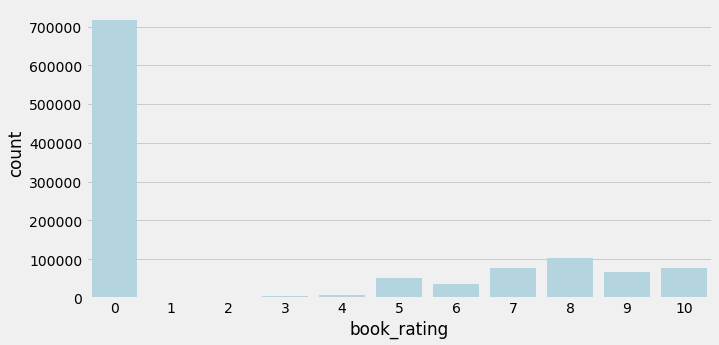

In [76]:
fig, ax = plt.subplots(figsize = (10,5))

sns.countplot(
    ratings_clean['book_rating'],
    color = 'lightblue'
)

In [63]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [64]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [65]:
users_clean = users.copy(deep = True)
users_clean = col_rename_f(users_clean)

# fill null value in age column
users_clean['age'].fillna(users_clean['age'].mode()[0], inplace = True)

In [66]:
# Converting User-ID and Age variable types to int
users_clean['user_id'] = users_clean['user_id'].astype('int')
users_clean['age'] = users_clean['age'].astype('int')

In [67]:
users_clean.head()

,user_id,location,age
0,1,"nyc, new york, usa",24
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",24
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",24


<AxesSubplot:xlabel='age'>

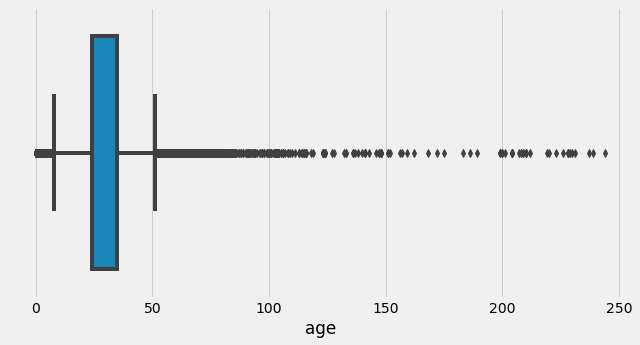

In [68]:
fig, ax = plt.subplots(figsize = (10,5))

sns.boxplot(
    users_clean['age']
)

We see the age of some users don't make sense, some of them have 0 and some others are older than 100. <br>
However, since we don't have any information on why is that the case, we will assume that this is due to human error and will still include them in our data.

In [69]:
df1=books_clean.merge(ratings_clean,how="left", on="isbn")
df_=df1.merge(users_clean,how="left", on="user_id")

df=df_.copy()
df.head()

,isbn,book_title,book_author,year_of_publication,publisher,mod_title,user_id,book_rating,location,age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,classical mythology,2.0,0.0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,8.0,5.0,"timmins, ontario, canada",24.0
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,11400.0,0.0,"ottawa, ontario, canada",49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,11676.0,8.0,"n/a, n/a, n/a",24.0
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,41385.0,0.0,"sudbury, ontario, canada",24.0


In [70]:
# remove null value
df.dropna(inplace=True)

#Removing books with zero ratings from the data set (optional)
df=df[df["book_rating"]>0]

In [71]:
df.head()

,isbn,book_title,book_author,year_of_publication,publisher,mod_title,user_id,book_rating,location,age
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,8.0,5.0,"timmins, ontario, canada",24.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,11676.0,8.0,"n/a, n/a, n/a",24.0
5,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,67544.0,8.0,"toronto, ontario, canada",30.0
8,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,116866.0,9.0,"ottawa, ,",24.0
9,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,123629.0,9.0,"kingston, ontario, canada",24.0


# Final Data

We are ready to create our first collaborative filtering book recommender.

In [28]:
df.to_csv('data/clean_data.csv')

## Next Step
1. Feature selection
    1. "Manual" feature selection
    1. PCA
    1. t-SNE(?)